#### Initialization

In [1]:
!nvidia-smi

Tue Jul  5 14:04:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! pip install kaggle -q

In [3]:
! pip install emoji -q

In [4]:
! pip install transformers -q

In [5]:
! pip install sentencepiece -q

In [6]:
! pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
! cp drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

In [15]:
! chmod 600  ~/.kaggle/kaggle.json

In [16]:
! kaggle datasets download nikosfragkis/greek-movies-dataset --force

 89% 25.0M/28.2M [00:01<00:00, 24.8MB/s]
100% 28.2M/28.2M [00:01<00:00, 25.9MB/s]


In [17]:
! mkdir ./athinorama

mkdir: cannot create directory ‘./athinorama’: File exists


In [18]:
! unzip -q greek-movies-dataset.zip -d ./athinorama 

#### Import Libraries

In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import re, string
import emoji
import nltk
from sklearn.utils import shuffle
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import TFGPT2Model
from transformers import GPT2TokenizerFast
from transformers import OpenAIGPTTokenizer, GPT2Tokenizer
from transformers import GPT2LMHeadModel, GPT2DoubleHeadsModel
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from wordcloud import WordCloud,STOPWORDS
from nltk.tokenize import sent_tokenize
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import pipeline
from tqdm.notebook import tqdm
from torch import optim
import torch.nn.functional as F
import copy
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import unicodedata
from nltk.corpus import stopwords
from matplotlib.pyplot import figure
from collections import defaultdict
from transformers import AutoTokenizer, AutoModel


from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)
from transformers import (
    T5Tokenizer, 
    T5Model,
    T5ForConditionalGeneration,
    get_linear_schedule_with_warmup
)


pd.options.mode.chained_assignment = None  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Functions

In [106]:
def strip_accents_and_lowercase(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn').lower()

def cleansing_create_sentiment_col(main_df):
  cleansed_data = []
  sentiments = []

  for v in main_df['review'].values:
    new_string = v.translate(str.maketrans('', '', string.punctuation))
    new_string = re.sub(r'http\S+', '', new_string) #remove urls
    cleansed_data.append(strip_accents_and_lowercase(new_string))

  for v in main_df['label'].values:
    if v == 0 :
      sentiments.append('negative')
    elif v == 1 :
      sentiments.append('neutral')
    elif v == 2 :
      sentiments.append('positive')

  main_df['review_cleansed'] = cleansed_data
  main_df['sentiment'] = sentiments
  return main_df

def create_gr_stopwords(stopwords):
  stopwords = set(stopwords.words('greek'))
  new_stopwords = []
  for s in stopwords:
    new_stopwords.append(strip_accents_and_lowercase(s))
  new_stopwords.append('μια')
  new_stopwords.append('μιας')
  new_stopwords.append('μου')
  new_stopwords.append('ενα')
  new_stopwords.append('σας')
  return new_stopwords

def get_ngrams(review, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(review)
    bag_of_words = vec.transform(review) #sparse matrix of count_vectorizer
    sum_words = bag_of_words.sum(axis=0) #total number of words
    sum_words = np.array(sum_words)[0].tolist() #convert to list
    words_freq = [(word, sum_words[idx]) for word, idx in vec.vocabulary_.items()] #get word freqency for word location in count vec
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) #key is used to perform sorting using word_freqency 
    return words_freq[:n]

def return_label(mystr):
  if 'positive' in mystr:
    return 'positive'
  elif 'neutral' in mystr:
    return 'neutral'
  elif 'negative' in mystr:
    return 'negative'

def colorize(value):
    if value is True:
      return 'background-color: lightgreen'


def create_BERT_score_df(score_df):
  tokenizer = Config_BERT.get('TOKENIZER')
  score_BERT_loader = create_BERT_Dloader(score_df[['review_cleansed','label']], tokenizer, Config_BERT['MAX_LEN'], Config_BERT['BATCH_SIZE'])
  device =  Config_BERT.get('DEVICE')
  loss_bert = nn.CrossEntropyLoss().to(device)
  t_reviews , dec_reviews , true_labels , pred_labels = score_bert(load_Greek_Bert_model,
                                                                    score_BERT_loader,
                                                                    loss_bert,
                                                                    tokenizer,
                                                                    device, 
                                                                    len(score_df))
  model_bname= []
  for i in range(len(dec_reviews)):
    model_bname.append('BERT')

  flatten_predicted = list(itertools.chain(*pred_labels))
  flatten_true_label = list(itertools.chain(*true_labels))
  flatten_review = list(itertools.chain(*t_reviews))
  cpu_flatten_predicted = torch.tensor(flatten_predicted, device = 'cpu')
  cpu_flatten_true_label = torch.tensor(flatten_true_label, device = 'cpu')

  d = {'Review':flatten_review,'BERT_Decoded_review':dec_reviews,'True Label': cpu_flatten_true_label ,'Predicted Label': cpu_flatten_predicted ,'Model Name':model_bname}
  dfbert = pd.DataFrame(d)
  dfbert.loc[dfbert["True Label"] == dfbert["Predicted Label"], ['BERT_Prediction']] = True
  dfbert.loc[dfbert["True Label"] != dfbert["Predicted Label"], ['BERT_Prediction']] = False
  return dfbert

def create_T5_score_df(score_df):
  score_T5_loader = T5_create_data_loader(score_df[['review_cleansed','sentiment']],Config_T5.get('BATCH_SIZE'))
  pred,predy,tr,pred_ids, dec_rev = T5_score(load_T5_model,score_T5_loader)
  model_name = []
  for d in dec_rev:
    model_name.append('MT5')
  d = {'T5_Decoded Review':dec_rev,'True Sentiment':tr,'Predicted Sentiment':pred,'T5_Decoded Sentiment':predy,'Model':model_name}
  T5_df = pd.DataFrame(d)
  T5_df.loc[T5_df["True Sentiment"] == T5_df["Predicted Sentiment"], ['MT5_Prediction']] = True
  T5_df.loc[T5_df["True Sentiment"] != T5_df["Predicted Sentiment"], ['MT5_Prediction']] = False
  return T5_df

def create_GPT2_score_df(score_df):
  tokenizer = Config_GPT2.get('TOKENIZER')
  score_GPT2_loader = create_GPT2_Dloader(score_df[['review_cleansed','label']], tokenizer, Config_GPT2['MAX_LEN'], Config_GPT2['BATCH_SIZE'])
  device =  Config_GPT2.get('DEVICE')
  loss_gpt2 = nn.CrossEntropyLoss().to(device)
  t_reviews , dec_reviews , true_labels , pred_labels = score_GPT2(model,
                                                                    score_GPT2_loader,
                                                                    loss_gpt2,
                                                                    tokenizer,
                                                                    device, 
                                                                    len(score_df))
  model_bname= []
  for i in range(len(dec_reviews)):
    model_bname.append('GPT2')

  flatten_predicted = list(itertools.chain(*pred_labels))
  flatten_true_label = list(itertools.chain(*true_labels))
  flatten_review = list(itertools.chain(*t_reviews))
  cpu_flatten_predicted = torch.tensor(flatten_predicted, device = 'cpu')
  cpu_flatten_true_label = torch.tensor(flatten_true_label, device = 'cpu')

  d = {'Review':flatten_review,'GPT2_Decoded_review':dec_reviews,'True Label': cpu_flatten_true_label ,'Predicted Label': cpu_flatten_predicted ,'Model Name':model_bname}
  dfgpt2 = pd.DataFrame(d)
  dfgpt2.loc[dfgpt2["True Label"] == dfgpt2["Predicted Label"], ['GPT2_Prediction']] = True
  dfgpt2.loc[dfgpt2["True Label"] != dfgpt2["Predicted Label"], ['GPT2_Prediction']] = False
  return dfgpt2

def create_our_score_df(score_df):
  tokenizer = Config_model.get('TOKENIZER')
  score_model_loader = create_model_Dloader(score_df[['review_cleansed','label']], tokenizer, Config_model['MAX_LEN'], Config_model['BATCH_SIZE'])
  device =  Config_model.get('DEVICE')
  loss_OUR = nn.CrossEntropyLoss().to(device)
  t_reviews , dec_reviews , true_labels , pred_labels = score_model(load_our_model,
                                                                    score_model_loader,
                                                                    loss_OUR,
                                                                    tokenizer,
                                                                    device, 
                                                                    len(score_df))
  model_bname= []
  for i in range(len(dec_reviews)):
    model_bname.append('OUR')

  flatten_predicted = list(itertools.chain(*pred_labels))
  flatten_true_label = list(itertools.chain(*true_labels))
  flatten_review = list(itertools.chain(*t_reviews))
  cpu_flatten_predicted = torch.tensor(flatten_predicted, device = 'cpu')
  cpu_flatten_true_label = torch.tensor(flatten_true_label, device = 'cpu')

  d = {'Review':flatten_review,'BERT_Decoded_review':dec_reviews,'True Label': cpu_flatten_true_label ,'Predicted Label': cpu_flatten_predicted ,'Model Name':model_bname}
  dfOUR = pd.DataFrame(d)
  dfOUR.loc[dfOUR["True Label"] == dfOUR["Predicted Label"], ['OUR_Prediction']] = True
  dfOUR.loc[dfOUR["True Label"] != dfOUR["Predicted Label"], ['OUR_Prediction']] = False
  return dfOUR

#### Data Exploration

In [21]:
df = pd.read_csv('/content/athinorama/Athinorama_movies_dataset.csv')  

In [22]:
df.head()

id number                                    greek title  \
0          0              Και Τώρα Κάτι Τελείως Διαφορετικό   
1          1              Και Τώρα Κάτι Τελείως Διαφορετικό   
2          2  Το Αδελφάτο των Ιπποτών της Ελεεινής Τραπέζης   
3          3  Το Αδελφάτο των Ιπποτών της Ελεεινής Τραπέζης   
4          4  Το Αδελφάτο των Ιπποτών της Ελεεινής Τραπέζης   

                               original title category  \
0  AND NOW FOR SOMETHING COMPLETELY DIFFERENT  Κωμωδία   
1  AND NOW FOR SOMETHING COMPLETELY DIFFERENT  Κωμωδία   
2             Monty Python and the Holy Grail  Κωμωδία   
3             Monty Python and the Holy Grail  Κωμωδία   
4             Monty Python and the Holy Grail  Κωμωδία   

                     director  movie lenght  movie date             author  \
0               Ίαν Μακ Νότον            88        1971             Marvin   
1               Ίαν Μακ Νότον            88        1971  Χριστόφορος Ζώνας   
2  Τέρι Γκίλιαμ, Τέρι Τζόουνς            91        1975             Vandim   
3  Τέρι Γκίλιαμ, Τέρι Τζόουνς            91        1975                 dH   
4  Τέρι Γκίλιαμ, Τέρι Τζόουνς            91        1975            Orestis   

   review date                                             review       stars  \
0         2002  Φοβερή η σύλληψη του χιούμορ από τους Python''...  4 αστεράκΑ   
1         2002  Από τις καλύτερς στιγμές των Μ.Π., ισάξιο μόνο...  5 αστεράκΑ   
2         2020  Κλασικό! Από τις καλύτερες και ανατρεπτικότερε...  4 αστεράκΑ   
3         2015  Μου θυμιζει τα κόμικ του Αστερίξ που όσο μεγάλ...  5 αστεράκΑ   
4         2014                                      Το κάτι άλλο!  5 αστεράκΑ   

   label  mean of stars  number of reviews  \
0    4.0            4.5                  2   
1    5.0            4.5                  2   
2    4.0            4.0                 32   
3    5.0            4.0                 32   
4    5.0            4.0                 32   

                                                 url  
0  https://www.athinorama.gr/cinema/movieratings....  
1  https://www.athinorama.gr/cinema/movieratings....  
2  https://www.athinorama.gr/cinema/movieratings....  
3  https://www.athinorama.gr/cinema/movieratings....  
4  https://www.athinorama.gr/cinema/movieratings....

In [23]:
print('In the main DataFrame we have {} rows & {} columns'.format(df.shape[0],df.shape[1]))
print('Total Columns in the main DataFrame : '+ str(df.columns.to_list()))
print('The unique movies are : '+ str(df['greek title'].nunique()))
print('For the main columns of reviews & labels we have no missing values, null values :'+ str(sum(df[['review','label']].isnull().sum())))

In the main DataFrame we have 148795 rows & 15 columns
Total Columns in the main DataFrame : ['id number', 'greek title', 'original title', 'category', 'director', 'movie lenght', 'movie date', 'author', 'review date', 'review', 'stars', 'label', 'mean of stars', 'number of reviews', 'url']
The unique movies are : 6481
For the main columns of reviews & labels we have no missing values, null values :0


In [24]:
# we focus only for the review and label columns
last_df = df[['review','label']]

In [25]:
# the count values for each label
last_df['label'].value_counts()

5.0    33541
4.0    25116
3.0    17687
0.0    15244
2.0    12014
1.0     9810
3.5     9796
4.5     9632
2.5     6514
0.5     5158
1.5     4283
Name: label, dtype: int64

In [26]:
# we map the label values to 3 different sentiments negative, neutral , positive with 0 ,1 ,2 labels respectfully
# [0,1.5] : negative , [2,3.5] : neutral , [4,5] : positive
last_df.loc[(last_df["label"] >= 0) & (last_df["label"] <= 1.5), ['label']] = 0
last_df.loc[(last_df["label"] >= 2) & (last_df["label"] <= 3.5), ['label']] = 1
last_df.loc[(last_df["label"] >= 4) & (last_df["label"] <= 5), ['label']] = 2

In [27]:
last_df = cleansing_create_sentiment_col(last_df)

In [28]:
last_df.head()

review  label  \
0  Φοβερή η σύλληψη του χιούμορ από τους Python''...    2.0   
1  Από τις καλύτερς στιγμές των Μ.Π., ισάξιο μόνο...    2.0   
2  Κλασικό! Από τις καλύτερες και ανατρεπτικότερε...    2.0   
3  Μου θυμιζει τα κόμικ του Αστερίξ που όσο μεγάλ...    2.0   
4                                      Το κάτι άλλο!    2.0   

                                     review_cleansed sentiment  
0  φοβερη η συλληψη του χιουμορ απο τους pythons ...  positive  
1  απο τις καλυτερς στιγμες των μπ ισαξιο μονο το...  positive  
2  κλασικο απο τις καλυτερες και ανατρεπτικοτερες...  positive  
3  μου θυμιζει τα κομικ του αστεριξ που οσο μεγαλ...  positive  
4                                       το κατι αλλο  positive

#### Data Visualizations

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


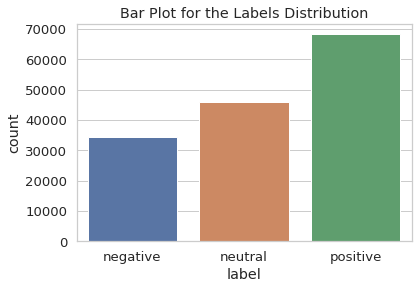

In [ ]:
sns.set(style = "whitegrid" , font_scale = 1.2)
sns.countplot(last_df.label,order = [0,1,2])
plt.xticks(ticks = np.arange(3),labels = ['negative','neutral','positive'])
plt.title('Bar Plot for the Labels Distribution')
plt.show()

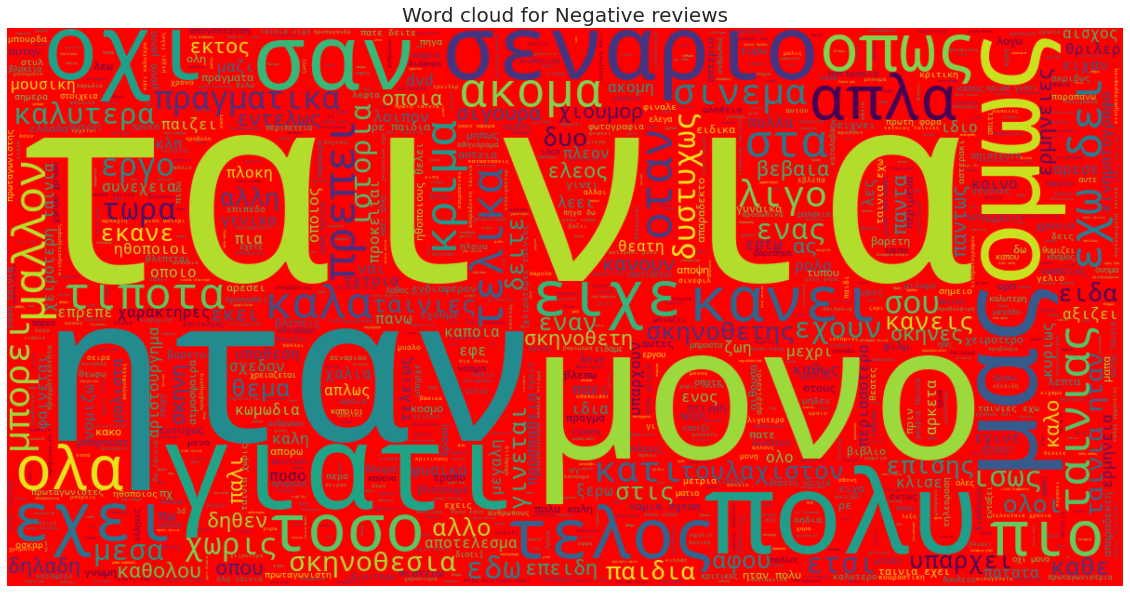

In [ ]:
new_stopwords = create_gr_stopwords(stopwords)

#word cloud for negative reviews
negative_data = last_df[last_df.label == 0]['review_cleansed']
negative_data_string = ' '.join(negative_data)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000, width=1200, height=600,background_color="red",stopwords=new_stopwords).generate(negative_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for Negative reviews',fontsize = 20)
plt.show()

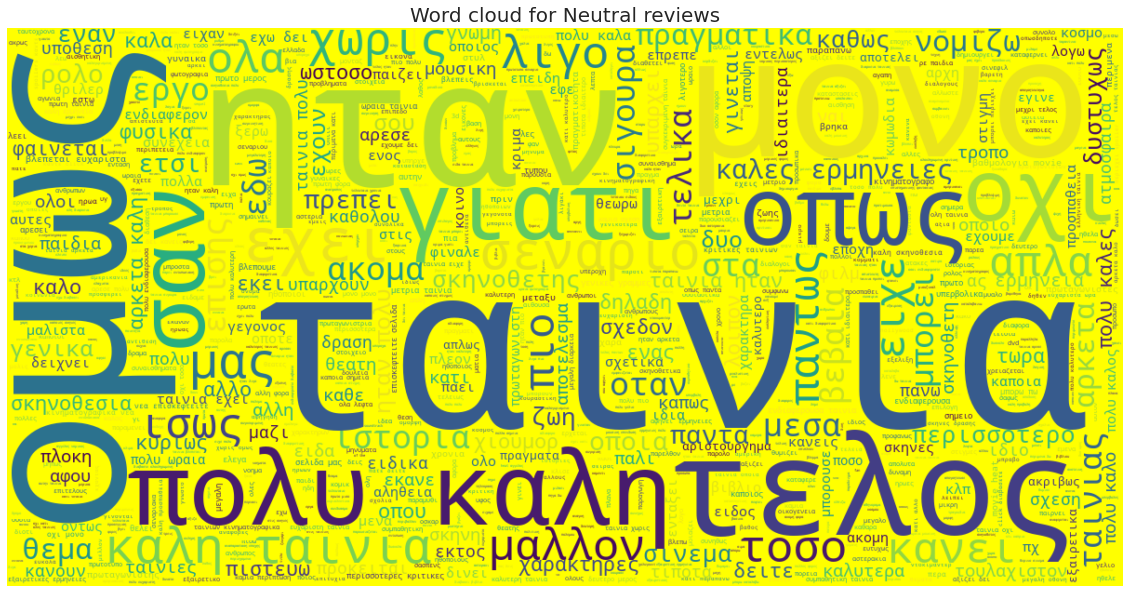

In [ ]:
#word cloud for Neutral reviews
negative_data = last_df[last_df.label == 1]['review_cleansed']
negative_data_string = ' '.join(negative_data)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000, width=1200, height=600,background_color="yellow",stopwords=new_stopwords).generate(negative_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for Neutral reviews',fontsize = 20)
plt.show()

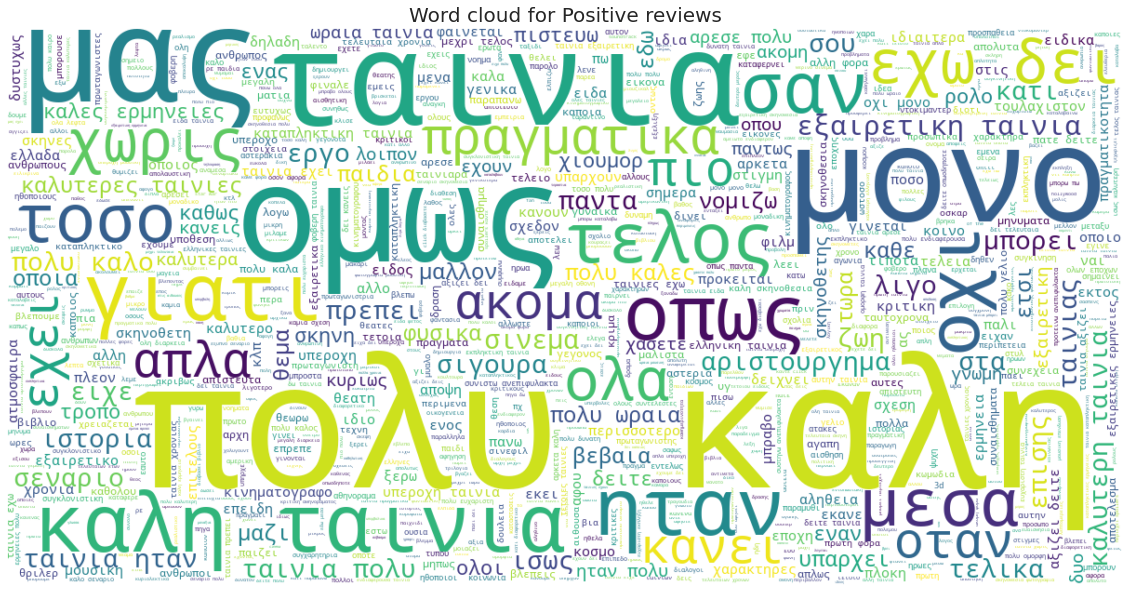

In [ ]:
#word cloud for Positive reviews
negative_data = last_df[last_df.label == 2]['review_cleansed']
negative_data_string = ' '.join(negative_data)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000, width=1200, height=600,background_color="white",stopwords=new_stopwords).generate(negative_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for Positive reviews',fontsize = 20)
plt.show()

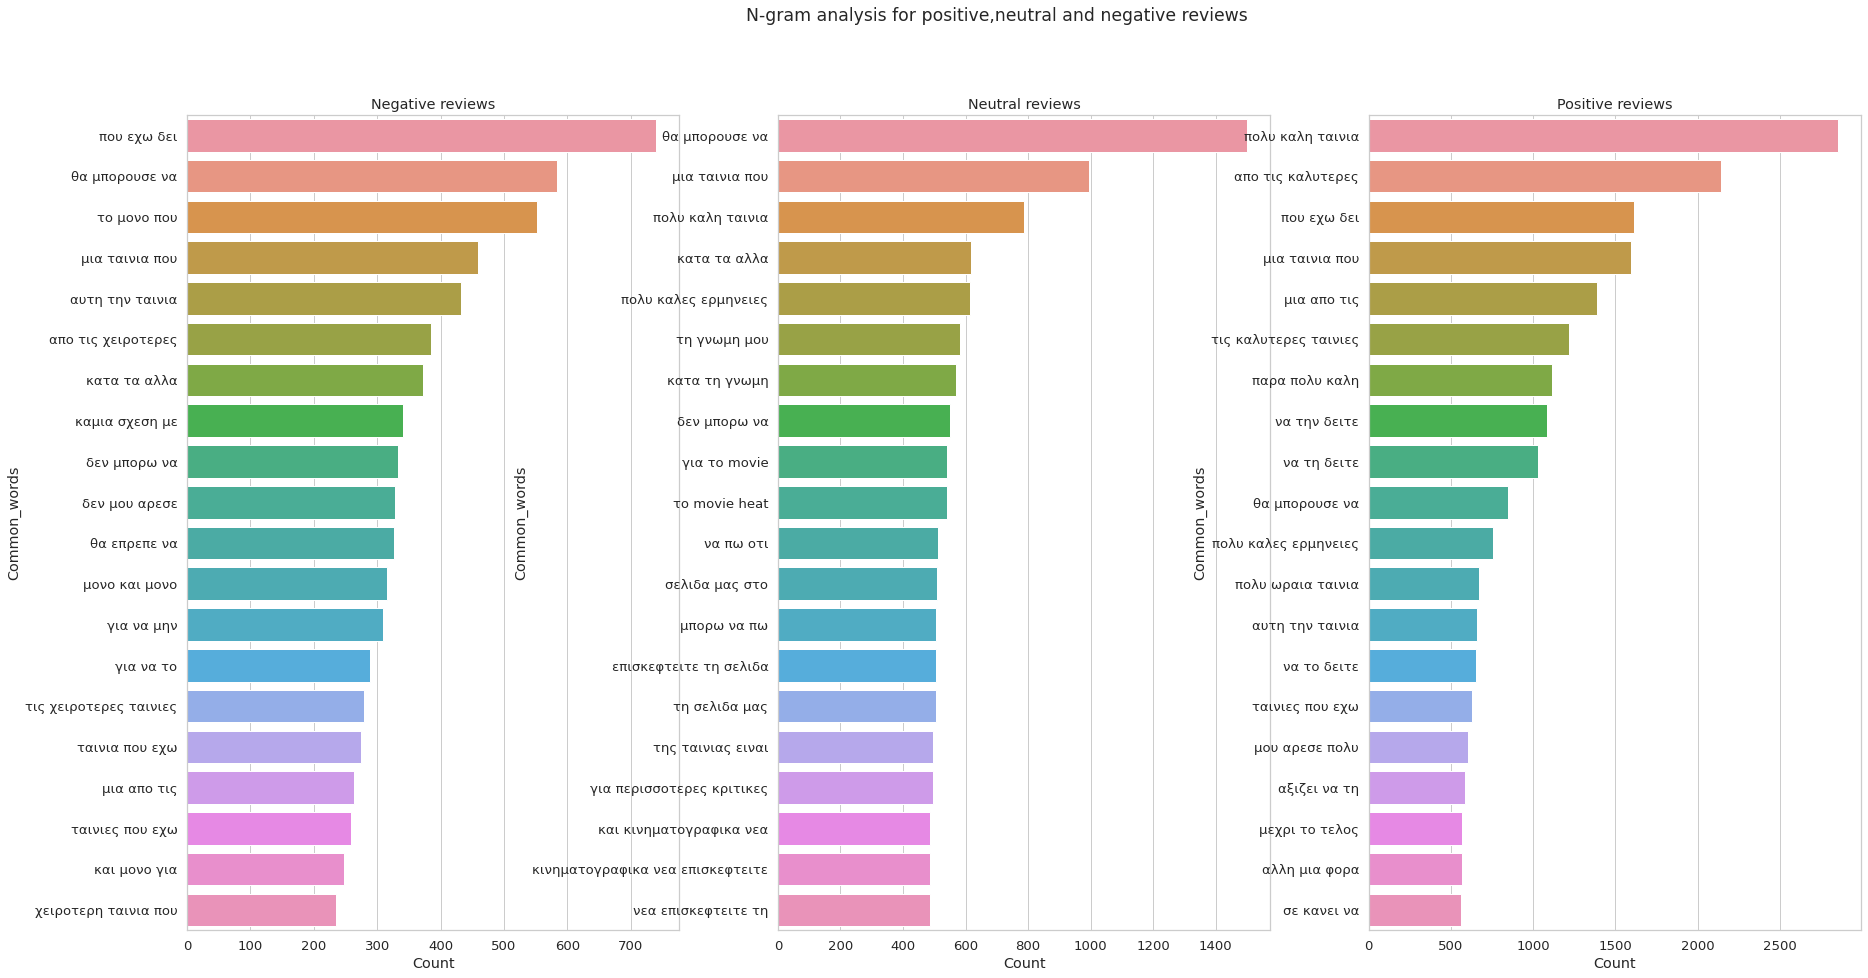

In [ ]:
negative_data = last_df[last_df.label == 0]['review_cleansed']
neutral_data = last_df[last_df.label == 1]['review_cleansed']
positive_data = last_df[last_df.label == 2]['review_cleansed']

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(30,15))

bi_negative = get_ngrams(negative_data,20,3)
bi_negative = dict(bi_negative)
temp = pd.DataFrame(list(bi_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax=ax1)

bi_neutral = get_ngrams(neutral_data,20,3)
bi_neutral = dict(bi_neutral)
temp = pd.DataFrame(list(bi_neutral.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax=ax2)

bi_positive = get_ngrams(positive_data,20,3)
bi_positive = dict(bi_positive)
temp = pd.DataFrame(list(bi_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax=ax3)


ax1.set_title('Negative reviews')
ax2.set_title('Neutral reviews')
ax3.set_title('Positive reviews')
fig.suptitle('N-gram analysis for positive,neutral and negative reviews')
plt.show()

#### Train - Test - Validation Split

In [29]:
last_df.head()

review  label  \
0  Φοβερή η σύλληψη του χιούμορ από τους Python''...    2.0   
1  Από τις καλύτερς στιγμές των Μ.Π., ισάξιο μόνο...    2.0   
2  Κλασικό! Από τις καλύτερες και ανατρεπτικότερε...    2.0   
3  Μου θυμιζει τα κόμικ του Αστερίξ που όσο μεγάλ...    2.0   
4                                      Το κάτι άλλο!    2.0   

                                     review_cleansed sentiment  
0  φοβερη η συλληψη του χιουμορ απο τους pythons ...  positive  
1  απο τις καλυτερς στιγμες των μπ ισαξιο μονο το...  positive  
2  κλασικο απο τις καλυτερες και ανατρεπτικοτερες...  positive  
3  μου θυμιζει τα κομικ του αστεριξ που οσο μεγαλ...  positive  
4                                       το κατι αλλο  positive

In [30]:
train, val = train_test_split(shuffle(last_df[['review_cleansed','sentiment','label']]),test_size=0.2)
test, val = train_test_split(val,test_size=0.5)

print('train rows :' + str(train.shape[0]))
print('validation rows :'+ str(val.shape[0]))
print('test rows :'+ str(test.shape[0]))


train rows :119036
validation rows :14880
test rows :14879


#### Greek Bert

In [53]:
Config_BERT = {'MODEL_PATH' : "nlpaueb/bert-base-greek-uncased-v1", 
              'TOKENIZER' : BertTokenizer.from_pretrained("nlpaueb/bert-base-greek-uncased-v1"),
              'BATCH_SIZE' : 128,
              'DEVICE' : torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
              'LR' : 2e-5,
              'EPOCHS' : 10,
              'SAVE_PATH': './drive/MyDrive/Models/GBERT_best_model.pt',
              'MAX_LEN': 128
              }

Downloading:   0%|          | 0.00/518k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/459 [00:00<?, ?B/s]

In [ ]:
tokenizer = Config_BERT.get('TOKENIZER')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


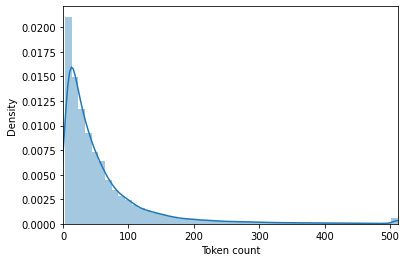

In [ ]:
token_lens = []

for txt in train.review_cleansed.to_list():
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))
  
sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

In [56]:
class Athinorama(Dataset):
    
    def __init__(self, reviews, labels, tokenizer, max_len):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.reviews)
    def __getitem__(self, item):
        
        reviews = str(self.reviews[item])
        labels = self.labels[item]
        encoding = self.tokenizer.encode_plus(reviews,
                                              add_special_tokens=True,
                                              max_length=self.max_len,
                                              return_token_type_ids=False,
                                              padding='max_length',
                                              return_attention_mask=True,
                                              truncation = True,
                                              return_tensors='pt')
        return {'reviews': reviews,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'labels': torch.tensor(labels, dtype=torch.long)
                }

def create_BERT_Dloader(data, tokenizer, max_len, batch_size):
    
    ds = Athinorama(reviews=data.review_cleansed.to_numpy(),
                    labels=data.label.to_numpy(),
                    tokenizer=tokenizer,
                    max_len=max_len)
    return DataLoader(ds,batch_size=batch_size,num_workers=4)

In [ ]:
train_data_loader = create_BERT_Dloader(train, tokenizer, Config_BERT['MAX_LEN'], Config_BERT['BATCH_SIZE'])
val_data_loader = create_BERT_Dloader(val, tokenizer, Config_BERT['MAX_LEN'], Config_BERT['BATCH_SIZE'])
test_data_loader = create_BERT_Dloader(test, tokenizer, Config_BERT['MAX_LEN'], Config_BERT['BATCH_SIZE'])

In [ ]:
# illustration of BERT tokenizer

gg = next(iter(train_data_loader))
gg.keys()

# decoding reviews from ids
illu_review = train.review_cleansed.to_numpy()[0]
print(illu_review)
print(' '.join(Config_BERT.get('TOKENIZER').convert_ids_to_tokens(gg['input_ids'][0])))
print('max length : '+ str(len(Config_BERT.get('TOKENIZER').convert_ids_to_tokens(gg['input_ids'][0]))))
print()


ωραια ταινια αν και περιμεναμε περισσοτερα απο το σκηνοθετη των σθνηθων υποπτωνενδιαφερουσα σκιαγραφηση χαρακτηρωναρκετα προβλεψιμο τελος
[CLS] ωραια ταινια αν και περιμεναμε περισσοτερα απο το σκηνοθετη των σ ##θνη ##θων υποπτ ##ων ##εν ##δια ##φερ ##ουσα σκιαγραφ ##ηση χαρακτηρων ##αρ ##κετ ##α προβλεψιμ ##ο τελος [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
max length : 128



In [59]:
class GreekBert(nn.Module):
    
    def __init__(self, n_classes):
        
        super(GreekBert, self).__init__()
        self.bert = BertModel.from_pretrained(Config_BERT.get('MODEL_PATH'))
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        
        _, pooled_output = self.bert(
                                      input_ids=input_ids,
                                      attention_mask=attention_mask,return_dict=False)
    
        output = self.drop(pooled_output)
        return self.out(output)

In [60]:
def train_bert(model,data_loader,loss_fn,optimizer,device,scheduler, n_examples,epoch):  
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in tqdm(data_loader,desc='Epoch ' + str(epoch)):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["labels"].to(device)
        outputs = model(input_ids=input_ids,attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

def validate_bert(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in tqdm(data_loader):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)
            outputs = model(input_ids=input_ids,attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
        return correct_predictions.double() / n_examples, np.mean(losses)

def score_bert(model, data_loader, loss_fn, tokenizer, device,n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    t_reviews = []
    dec_reviews= []
    true_labels= []
    pred_labels= []
    
    with torch.no_grad():
        for d in tqdm(data_loader):
            temp_reviews = d["reviews"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)

            for i in input_ids:
              dec_reviews.append(tokenizer.decode(i))

            outputs = model(input_ids=input_ids,attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            t_reviews.append(temp_reviews)
            true_labels.append(targets)
            pred_labels.append(preds)

        accc = correct_predictions.double() / n_examples
        print('Accucary : '+str(100*accc.tolist())+' %')
        print('Correct : '+ str(correct_predictions.tolist()))
        print('Total : '+ str(n_examples))

        return t_reviews , dec_reviews , true_labels , pred_labels

In [ ]:
model = GreekBert(n_classes=3)
model = model.to(Config_BERT.get('DEVICE'))

Downloading:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def run_gbert():
  ### hyperparameters ###
  optimizer = optim.AdamW(model.parameters(), lr=Config_BERT.get('LR'), )
  total_steps = len(train_data_loader) * Config_BERT.get('EPOCHS')
  scheduler = get_linear_schedule_with_warmup(optimizer,
                                              num_warmup_steps=0,
                                              num_training_steps=total_steps)
  loss_fn = nn.CrossEntropyLoss().to(Config_BERT.get('DEVICE'))

  history = defaultdict(list)
  best_accuracy = 0
  start = time.time()

  for epoch in range(Config_BERT.get('EPOCHS')):
      train_acc, train_loss = train_bert(model,train_data_loader,loss_fn,optimizer,Config_BERT.get('DEVICE'),scheduler,len(train),epoch)
      print(f'Train loss {train_loss} accuracy {train_acc}')
      val_acc, val_loss = validate_bert(model,val_data_loader,loss_fn,Config_BERT.get('DEVICE'),len(val))
      print(f'Validation loss {val_loss} accuracy {val_acc}')
      print()

      history['train_acc'].append(train_acc)
      history['train_loss'].append(train_loss)
      history['val_acc'].append(val_acc)
      history['val_loss'].append(val_loss)

      if val_acc > best_accuracy:
          torch.save(model.state_dict(), Config_BERT.get('SAVE_PATH'))
          best_accuracy = val_acc

      print(f'Best Validation Accuracy  : {best_accuracy}')
      print()
  end = time.time()
  training_time = round((end - start)/60,3)
  print('Training finished in {} minutes.'.format(str(training_time)))
  return history



In [ ]:
bert_history = run_gbert()

Epoch 0:   0%|          | 0/930 [00:00<?, ?it/s]

Train loss 0.6233273231534547 accuracy 0.7250495648375282


  0%|          | 0/117 [00:00<?, ?it/s]

Validation loss 0.5654966237708035 accuracy 0.7610887096774194

Best Validation Accuracy  : 0.7610887096774194



Epoch 1:   0%|          | 0/930 [00:00<?, ?it/s]

Train loss 0.5098736156058568 accuracy 0.7835780772203368


  0%|          | 0/117 [00:00<?, ?it/s]

Validation loss 0.5695196514965123 accuracy 0.7665322580645161

Best Validation Accuracy  : 0.7665322580645161



Epoch 2:   0%|          | 0/930 [00:00<?, ?it/s]

Train loss 0.4406489045389237 accuracy 0.8162572667092309


  0%|          | 0/117 [00:00<?, ?it/s]

Validation loss 0.5866584439053495 accuracy 0.7700268817204301

Best Validation Accuracy  : 0.7700268817204301



Epoch 3:   0%|          | 0/930 [00:00<?, ?it/s]

Train loss 0.3783284207024882 accuracy 0.8468950569575592


  0%|          | 0/117 [00:00<?, ?it/s]

Validation loss 0.6326372371270106 accuracy 0.767002688172043

Best Validation Accuracy  : 0.7700268817204301



Epoch 4:   0%|          | 0/930 [00:00<?, ?it/s]

Train loss 0.3238629264216269 accuracy 0.8714254511240298


  0%|          | 0/117 [00:00<?, ?it/s]

Validation loss 0.6721334829289689 accuracy 0.7651209677419355

Best Validation Accuracy  : 0.7700268817204301



Epoch 5:   0%|          | 0/930 [00:00<?, ?it/s]

Train loss 0.27725095871475436 accuracy 0.8927299304412112


  0%|          | 0/117 [00:00<?, ?it/s]

Validation loss 0.7213327561178778 accuracy 0.761760752688172

Best Validation Accuracy  : 0.7700268817204301



Epoch 6:   0%|          | 0/930 [00:00<?, ?it/s]

Train loss 0.2415448598283273 accuracy 0.9064820726502908


  0%|          | 0/117 [00:00<?, ?it/s]

Validation loss 0.7801403293752263 accuracy 0.7624327956989247

Best Validation Accuracy  : 0.7700268817204301



Epoch 7:   0%|          | 0/930 [00:00<?, ?it/s]

Train loss 0.21291413044416777 accuracy 0.9190328976108069


  0%|          | 0/117 [00:00<?, ?it/s]

Validation loss 0.8291577003959917 accuracy 0.7613575268817204

Best Validation Accuracy  : 0.7700268817204301



Epoch 8:   0%|          | 0/930 [00:00<?, ?it/s]

Train loss 0.1920122769090437 accuracy 0.9278789609865924


  0%|          | 0/117 [00:00<?, ?it/s]

Validation loss 0.8421379404190259 accuracy 0.760752688172043

Best Validation Accuracy  : 0.7700268817204301



Epoch 9:   0%|          | 0/930 [00:00<?, ?it/s]

Train loss 0.17603432041823222 accuracy 0.9341963775664506


  0%|          | 0/117 [00:00<?, ?it/s]

Validation loss 0.8671738586874089 accuracy 0.7557123655913979

Best Validation Accuracy  : 0.7700268817204301

Training finished in 213.804 minutes.


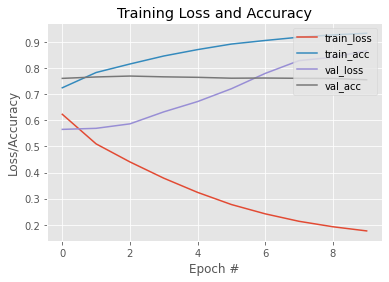

<Figure size 720x720 with 0 Axes>

In [ ]:
N= 10
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), bert_history["train_loss"], label="train_loss")
plt.plot(np.arange(0, N), bert_history["train_acc"], label="train_acc")
plt.plot(np.arange(0, N), bert_history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), bert_history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.figure(figsize = (10,10))
plt.show()

#### T5 Model

In [54]:
Config_T5 = {'MODEL_PATH' : 'google/mt5-small',
              'SRC_MAX_LENGTH' : 128,
              'TGT_MAX_LENGTH' : 3,   
              'TOKENIZER' : T5Tokenizer.from_pretrained('google/mt5-small'),
              'BATCH_SIZE' : 16,
              'DEVICE' : torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
              'LR' : 3e-5,
              'EPOCHS' : 4,
              'SAVE_PATH': './drive/MyDrive/Models/T5_best_second_model.pt'
              }

Downloading:   0%|          | 0.00/4.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/553 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


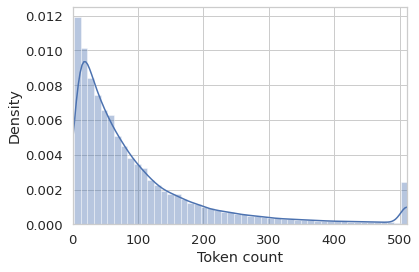

In [ ]:
token_lens = []
T5_tokenizer = Config_T5.get('TOKENIZER')
for txt in train.review_cleansed.to_list():
  tokens = T5_tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

In [57]:
def T5_create_data_loader(data, batch_size):
    ds = T5Dataset(reviews = data.review_cleansed.to_numpy(),labels = data.sentiment.to_numpy())
    return DataLoader(ds,batch_size=batch_size,num_workers=4)

class T5Dataset(Dataset):
    def __init__(self,reviews,labels):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = Config_T5.get('TOKENIZER')
        self.src_max_length = Config_T5.get('SRC_MAX_LENGTH')
        self.tgt_max_length = Config_T5.get('TGT_MAX_LENGTH')

    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, index):
        src_tokenized = self.tokenizer.encode_plus(
            str(self.reviews[index]), 
            max_length=self.src_max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        src_input_ids = src_tokenized['input_ids'].squeeze()
        src_attention_mask = src_tokenized['attention_mask'].squeeze()

        tgt_tokenized = self.tokenizer.encode_plus(
            str(self.labels[index]), 
            max_length=self.tgt_max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        tgt_input_ids = tgt_tokenized['input_ids'].squeeze()
        tgt_attention_mask = tgt_tokenized['attention_mask'].squeeze()

        return {
            'src_input_ids': src_input_ids.long(),
            'src_attention_mask': src_attention_mask.long(),
            'tgt_input_ids': tgt_input_ids.long(),
            'tgt_attention_mask': tgt_attention_mask.long()
        }

class T5Model(nn.Module):
    def __init__(self):
        super(T5Model, self).__init__()

        self.t5_model = T5ForConditionalGeneration.from_pretrained(Config_T5.get('MODEL_PATH'))

    def forward(
        self,
        input_ids, 
        attention_mask=None, 
        decoder_input_ids=None, 
        decoder_attention_mask=None, 
        lm_labels=None
        ):

        return self.t5_model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=lm_labels,
        )

In [ ]:
train_data_loader = T5_create_data_loader(train,Config_T5.get('BATCH_SIZE'))
val_data_loader = T5_create_data_loader(val,Config_T5.get('BATCH_SIZE'))
test_data_loader = T5_create_data_loader(test,Config_T5.get('BATCH_SIZE'))

print(len(train_data_loader))
print(len(val_data_loader))
print(len(test_data_loader))

7440
930
930


In [ ]:
# illustration of T5 tokenizer

gg = next(iter(train_data_loader))
gg.keys()

# decoding reviews from ids
illu_review = train.review_cleansed.to_numpy()[0]
print(illu_review)
print(' '.join(Config_T5.get('TOKENIZER').convert_ids_to_tokens(gg['src_input_ids'][0])))
print('max length : '+ str(len(Config_T5.get('TOKENIZER').convert_ids_to_tokens(gg['src_input_ids'][0]))))

print()

# decoding labels from ids
illu_sentiment = train.sentiment.to_numpy()[0]
print(illu_sentiment)
print(' '.join(Config_T5.get('TOKENIZER').convert_ids_to_tokens(gg['tgt_input_ids'][0])))
print('max length : '+ str(len(Config_T5.get('TOKENIZER').convert_ids_to_tokens(gg['tgt_input_ids'][0]))))

ως τωρα την εχω δει δυο φορες και θα ξαναπηγαινα ευχαριστως ειναι εξαιρετικη με εκπληκτικα εφε δυνατες συγκινησεις και μια μαγικη ιστορια να διηγηθει  ιδανικη για οποιοδηποτε ζευγαρι η μια μεικτη παρεα ανεξαρτητου ηλικιας
▁ ως ▁τ ωρα ▁ την ▁ε χω ▁ δει ▁δυ ο ▁φορ ες ▁και ▁θα ▁ξανα πη γα ινα ▁ευχαριστ ως ▁ ει ναι ▁ε ξαιρετικ η ▁με ▁εκ πληκτ ικα ▁εφ ε ▁ δυνατ ες ▁συγκ ινη σεις ▁και ▁ μια ▁μαγ ικη ▁ιστορ ια ▁να ▁δι ηγ η θει ▁ ιδα νικη ▁για ▁ οποιο δη ποτε ▁ζε υγ αρι ▁ η ▁ μια ▁μει κτη ▁παρε α ▁αν εξ αρτη του ▁ η λικ ιας </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
max length : 128

positive
▁positive </s> <pad>
max length : 3


In [61]:
def T5_predict(model,my_data_loader):
    pred = []
    predy = []
    tr_lbs = []
    tr_ids = []
    
    model.eval()
    for step, batch in tqdm(enumerate(my_data_loader), total=len(my_data_loader)):
      b_src_input_ids = batch['src_input_ids'].to(Config_T5.get('DEVICE'))
      b_src_attention_mask = batch['src_attention_mask'].to(Config_T5.get('DEVICE'))
      true_labels = batch['tgt_input_ids'].to(Config_T5.get('DEVICE'))

      with torch.no_grad():
          pred_ids = model.t5_model.generate(input_ids=b_src_input_ids, attention_mask=b_src_attention_mask)
          pred_ids = pred_ids.cpu().numpy()

          for t in true_labels.cpu().numpy():
              tr_ids.append(t)
              tr_lbs.append( return_label(Config_T5.get('TOKENIZER').decode(t)))
          for pred_id in pred_ids:
              pred_decoded = Config_T5.get('TOKENIZER').decode(pred_id)
              pred.append(return_label(pred_decoded))
              predy.append(pred_decoded)

    accc = sum(1 for x,y in zip(pred , tr_lbs) if x == y) / len(pred)
    print('Accucary : '+str(100*round(accc,3))+' %')
    print('Correct : '+ str(sum(1 for x,y in zip(pred , tr_lbs) if x == y)))
    print('Total : '+ str(len(pred)))
    return pred,predy,tr_lbs,pred_ids,tr_ids

#############################################################################

def T5_score(model,my_data_loader):
    pred = []
    predy = []
    tr_lbs = []
    tr_ids = []
    tr_reviews = []
    
    model.eval()
    for step, batch in tqdm(enumerate(my_data_loader), total=len(my_data_loader)):
      b_src_input_ids = batch['src_input_ids'].to(Config_T5.get('DEVICE'))
      b_src_attention_mask = batch['src_attention_mask'].to(Config_T5.get('DEVICE'))
      true_labels = batch['tgt_input_ids'].to(Config_T5.get('DEVICE'))

      with torch.no_grad():
          pred_ids = model.t5_model.generate(input_ids=b_src_input_ids, attention_mask=b_src_attention_mask)
          pred_ids = pred_ids.cpu().numpy()

          for t in b_src_input_ids.cpu().numpy():
              tr_reviews.append( Config_T5.get('TOKENIZER').decode(t))

          for t in true_labels.cpu().numpy():
              tr_ids.append(t)
              tr_lbs.append( return_label(Config_T5.get('TOKENIZER').decode(t)))

          for pred_id in pred_ids:
              pred_decoded = Config_T5.get('TOKENIZER').decode(pred_id)
              pred.append(return_label(pred_decoded))
              predy.append(pred_decoded)

    accc = sum(1 for x,y in zip(pred , tr_lbs) if x == y) / len(pred)
    print('Accucary : '+str(100*round(accc,3))+' %')
    print('Correct : '+ str(sum(1 for x,y in zip(pred , tr_lbs) if x == y)))
    print('Total : '+ str(len(pred)))

    return pred,predy,tr_lbs,pred_ids,tr_reviews

#############################################################################

def T5_validation(model, val_dataloader, criterion):
    
    val_loss = 0
    true, pred = [], []
    
    model.eval()
    
    for step, batch in enumerate(val_dataloader):
        b_src_input_ids = batch['src_input_ids'].to(Config_T5.get('DEVICE'))
        b_src_attention_mask = batch['src_attention_mask'].to(Config_T5.get('DEVICE'))
        temp = batch['tgt_input_ids']
        b_tgt_input_ids = batch['tgt_input_ids'].to(Config_T5.get('DEVICE'))
        lm_labels = b_tgt_input_ids.to(Config_T5.get('DEVICE'))
        lm_labels[lm_labels[:, :] == Config_T5.get('TOKENIZER').pad_token_id] = -100
        b_tgt_attention_mask = batch['tgt_attention_mask'].to(Config_T5.get('DEVICE'))

        with torch.no_grad():
            outputs = model(
                input_ids=b_src_input_ids, 
                attention_mask=b_src_attention_mask,
                lm_labels=lm_labels,
                decoder_attention_mask=b_tgt_attention_mask)
            

            loss = outputs[0]
            val_loss += loss.item()

            for true_id in temp:
                true_decoded = Config_T5.get('TOKENIZER').decode(true_id)
                true.append(return_label(true_decoded))

            pred_ids = model.t5_model.generate(
                input_ids=b_src_input_ids, 
                attention_mask=b_src_attention_mask
            )
            pred_ids = pred_ids.cpu().numpy()
            for pred_id in pred_ids:
                pred_decoded = Config_T5.get('TOKENIZER').decode(pred_id)
                pred.append(return_label(pred_decoded))



    avg_val_loss = val_loss / len(val_dataloader)
    print('Validation loss :', avg_val_loss)

    accc = sum(1 for x,y in zip(pred , true) if x == y) / len(pred)
    print('Validation accuracy :'+str(100*round(accc,4)))
    return accc ,avg_val_loss

#############################################################################

def T5_train(model,train_dataloader,criterion,optimizer,scheduler, epoch):
  
    train_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader, desc='Epoch ' + str(epoch))):
        model.train()
        
        b_src_input_ids = batch['src_input_ids'].to(Config_T5.get('DEVICE'))
        b_src_attention_mask = batch['src_attention_mask'].to(Config_T5.get('DEVICE'))
    
        lm_labels = batch['tgt_input_ids'].to(Config_T5.get('DEVICE'))
        lm_labels[lm_labels[:, :] == Config_T5.get('TOKENIZER').pad_token_id] = -100

        b_tgt_attention_mask = batch['tgt_attention_mask'].to(Config_T5.get('DEVICE'))

        # clear accumulated gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(input_ids=b_src_input_ids, 
                        attention_mask=b_src_attention_mask,
                        lm_labels=lm_labels,
                        decoder_attention_mask=b_tgt_attention_mask)
        

        loss = outputs[0]
        train_loss += loss.item()

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()
        
        # update scheduler
        scheduler.step()

    avg_train_loss = train_loss / len(train_dataloader)
    print('Training loss : ', avg_train_loss)
    return avg_train_loss

#############################################################################

def run():
    T5_history = defaultdict(list)

    criterion = nn.CrossEntropyLoss()
    
    # define the parameters to be optmized -
    # - and add regularization
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer = optim.AdamW(model.parameters(), lr=Config_T5.get('LR'))

    num_training_steps = len(train_data_loader) * Config_T5.get('EPOCHS')
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps)

    start = time.time()

    max_val_accuracy = float('-inf')
    for epoch in range(Config_T5.get('EPOCHS')):

        train_loss = T5_train(model, train_data_loader, criterion, optimizer, scheduler, epoch)
        val_accuracy , val_loss = T5_validation(model, val_data_loader, criterion)

        T5_history['train_loss'].append(train_loss)
        T5_history['val_acc'].append(val_accuracy)
        T5_history['val_loss'].append(val_loss)

        if val_accuracy > max_val_accuracy:
            best_model = copy.deepcopy(model)
            max_val_accuracy = val_accuracy

            torch.save(best_model.state_dict(),Config_T5.get('SAVE_PATH') )

            print()
            print(f'Best Validation Accuracy  : {max_val_accuracy}')
            print()

    end = time.time()
    training_time = round((end - start)/60,3)
    print('Training finished in {} minutes.'.format(str(training_time)))

    return best_model, T5_history

In [ ]:
model = T5Model()
model.to(Config_T5.get('DEVICE'));

cuda


You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


In [ ]:
best_model, T5_history  = run()

Epoch 0:   0%|          | 0/7440 [00:00<?, ?it/s]

Training loss :  2.9103008291814274
Validation loss : 0.5397710056715114
Validation accuracy :46.29
Best Validation Accuracy : 0.4629032258064516



Epoch 1:   0%|          | 0/7440 [00:00<?, ?it/s]

Training loss :  0.6457789749347715
Validation loss : 0.449323984275582
Validation accuracy :48.33
Best Validation Accuracy : 0.48333333333333334



Epoch 2:   0%|          | 0/7440 [00:00<?, ?it/s]

Training loss :  0.46885874790730336
Validation loss : 0.3845409092563455
Validation accuracy :60.540000000000006
Best Validation Accuracy : 0.6054435483870968



Epoch 3:   0%|          | 0/7440 [00:00<?, ?it/s]

Training loss :  0.38931223368772894
Validation loss : 0.33193514764469156
Validation accuracy :68.08
Best Validation Accuracy : 0.6808467741935483



Epoch 4:   0%|          | 0/7440 [00:00<?, ?it/s]

Training loss :  0.35090629357484077
Validation loss : 0.3091241868272904
Validation accuracy :70.85000000000001
Best Validation Accuracy : 0.7084677419354839



Epoch 5:   0%|          | 0/7440 [00:00<?, ?it/s]

Training loss :  0.33140830244989167
Validation loss : 0.3018685035487657
Validation accuracy :71.77
Best Validation Accuracy : 0.7176747311827957



Epoch 6:   0%|          | 0/7440 [00:00<?, ?it/s]

Training loss :  0.3194283362257705
Validation loss : 0.29279788165323195
Validation accuracy :72.37
Best Validation Accuracy : 0.7236559139784946



Epoch 7:   0%|          | 0/7440 [00:00<?, ?it/s]

Training loss :  0.3110801397902911
Validation loss : 0.291995509253234
Validation accuracy :72.55
Best Validation Accuracy : 0.7254704301075269



Epoch 8:   0%|          | 0/7440 [00:00<?, ?it/s]

Training loss :  0.30753720612715807
Validation loss : 0.29011611920050395
Validation accuracy :72.91
Best Validation Accuracy : 0.7290994623655914



Epoch 9:   0%|          | 0/7440 [00:00<?, ?it/s]

Training loss :  0.30374945144179044
Validation loss : 0.2862042939150205
Validation accuracy :73.49
Best Validation Accuracy : 0.7349462365591398



Epoch 10:   0%|          | 0/7440 [00:00<?, ?it/s]

Training loss :  0.2995505228828919
Validation loss : 0.284485194119074
Validation accuracy :73.45


Epoch 11:   0%|          | 0/7440 [00:00<?, ?it/s]

Training loss :  0.29721579392670944
Validation loss : 0.28365025426191026
Validation accuracy :73.42999999999999


Epoch 12:   0%|          | 0/7440 [00:00<?, ?it/s]

Training loss :  0.2955693253746597
Validation loss : 0.28360770854658335
Validation accuracy :73.44000000000001


In [ ]:
torch.cuda.empty_cache()

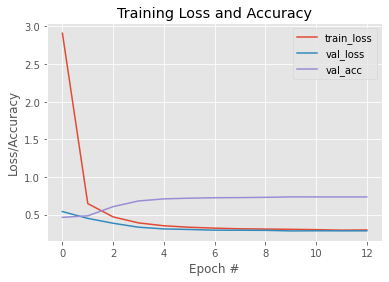

<Figure size 720x720 with 0 Axes>

In [ ]:
N= 13
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), T5_history["train_loss"], label="train_loss")
plt.plot(np.arange(0, N), T5_history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), T5_history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.figure(figsize = (10,10))
plt.show()

#### Greek GPT 2

In [102]:
Config_GPT2 = {'MODEL_PATH' : "nikokons/gpt2-greek", 
              'TOKENIZER' : GPT2Tokenizer.from_pretrained("nikokons/gpt2-greek"),
              'BATCH_SIZE' : 16,
              'DEVICE' : torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
              'LR' : 2e-5,
              'EPOCHS' : 4,
              'SAVE_PATH': './drive/MyDrive/Models/GPT2_best_model.pt',
              'MAX_LEN': 128
              }

In [110]:
ATTR_TO_SPECIAL_TOKEN = {'bos_token': '<bos>', 'eos_token': '<eos>', 'pad_token': '<pad>',
                         'additional_special_tokens': ['<speaker1>', '<speaker2>']}

tokenizer = Config_GPT2.get('TOKENIZER')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

1

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


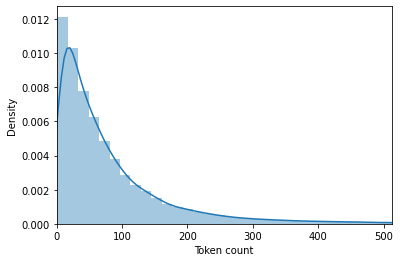

In [33]:
token_lens = []

for txt in train.review_cleansed.to_list():
  tokens = tokenizer.encode(txt, max_length=800)
  token_lens.append(len(tokens))
  
sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

In [89]:
class Athinorama(Dataset):
    
    def __init__(self, reviews, labels, tokenizer, max_len):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.reviews)
    def __getitem__(self, item):
        
        reviews = str(self.reviews[item])
        labels = self.labels[item]
        
        encoding = self.tokenizer.encode_plus(reviews,
                                              add_special_tokens=True,
                                              max_length=self.max_len,
                                              return_token_type_ids=True,
                                              padding='max_length',
                                              return_attention_mask=True,
                                              truncation = True,
                                              return_tensors='pt')
        return {'reviews': reviews,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'labels': torch.tensor(labels, dtype=torch.long)
                }

def create_GPT2_Dloader(data, tokenizer, max_len, batch_size):
    
    ds = Athinorama(reviews=data.review_cleansed.to_numpy(),
                    labels=data.label.to_numpy(),
                    tokenizer=tokenizer,
                    max_len=max_len)
    return DataLoader(ds,batch_size=batch_size,num_workers=4)

In [107]:
def train_GPT2(model,data_loader,loss_fn,optimizer,device,scheduler, n_examples,epoch):  
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in tqdm(data_loader,desc='Epoch ' + str(epoch)):
        
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["labels"].to(device)
        #position_ids = torch.stack([torch.arange(config.max_position_embeddings) for a in range(val_dataloader.batch_size)]).to(device)

        outputs = model(input_ids=input_ids.float().long().squeeze(0),attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

def validate_GPT2(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in tqdm(data_loader):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)
            outputs = model(input_ids=input_ids.float().long(),attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
        return correct_predictions.double() / n_examples, np.mean(losses)

def score_GPT2(model, data_loader, loss_fn, tokenizer, device,n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    t_reviews = []
    dec_reviews= []
    true_labels= []
    pred_labels= []
    
    with torch.no_grad():
        for d in tqdm(data_loader):
            temp_reviews = d["reviews"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)
  
            for i in input_ids:
              dec_reviews.append(tokenizer.decode(i))

            outputs = model(input_ids=input_ids.float().long(),attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            t_reviews.append(temp_reviews)
            true_labels.append(targets)
            pred_labels.append(preds)

        accc = correct_predictions.double() / n_examples
        print('Accucary : '+str(100*accc.tolist())+' %')
        print('Correct : '+ str(correct_predictions.tolist()))
        print('Total : '+ str(n_examples))

        return t_reviews , dec_reviews , true_labels , pred_labels

In [91]:
class GreekGPT2(nn.Module):
    
    def __init__(self, tokenizer, n_classes):
        
        super(GreekGPT2, self).__init__()
        self.gpt2 = GPT2DoubleHeadsModel.from_pretrained(Config_GPT2.get('MODEL_PATH'))
        add_special_tokens_(self.gpt2, tokenizer)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(22005, n_classes)
        
    def forward(self, input_ids, attention_mask):
        
        pooled_output = self.gpt2(
                                      input_ids=input_ids,
                                      attention_mask=attention_mask,
                                      return_dict=False)
    
        output = self.drop(pooled_output[0])

        output = torch.mean(output, dim=1)
        #output = output[:,0,:].squeeze()

        out = self.out(output)

        return out

In [92]:
def add_special_tokens_(model, tokenizer):
    """ Add special tokens to the tokenizer and the model if they have not already been added. """
    orig_num_tokens = len(tokenizer.encoder)
    num_added_tokens = tokenizer.add_special_tokens(ATTR_TO_SPECIAL_TOKEN) # doesn't add if they are already there
    if num_added_tokens > 0:
        model.resize_token_embeddings(new_num_tokens=orig_num_tokens + num_added_tokens)
        

In [93]:
model = GreekGPT2(tokenizer, n_classes=3)
model = model.to(Config_GPT2.get('DEVICE'))

Some weights of GPT2DoubleHeadsModel were not initialized from the model checkpoint at nikokons/gpt2-greek and are newly initialized: ['multiple_choice_head.summary.weight', 'multiple_choice_head.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [94]:
train_data_loader = create_GPT2_Dloader(train, tokenizer, Config_GPT2['MAX_LEN'], Config_GPT2['BATCH_SIZE'])
val_data_loader = create_GPT2_Dloader(val, tokenizer, Config_GPT2['MAX_LEN'], Config_GPT2['BATCH_SIZE'])
test_data_loader = create_GPT2_Dloader(test, tokenizer, Config_GPT2['MAX_LEN'], Config_GPT2['BATCH_SIZE'])

In [95]:
def run_gGPT2():
  ### hyperparameters ###
  optimizer = optim.AdamW(model.parameters(), lr=Config_GPT2.get('LR'), )
  total_steps = len(train_data_loader) * Config_GPT2.get('EPOCHS')
  scheduler = get_linear_schedule_with_warmup(optimizer,
                                              num_warmup_steps=0,
                                              num_training_steps=total_steps)
  loss_fn = nn.CrossEntropyLoss().to(Config_GPT2.get('DEVICE'))

  history = defaultdict(list)
  best_accuracy = 0
  start = time.time()

  for epoch in range(Config_GPT2.get('EPOCHS')):
      train_acc, train_loss = train_GPT2(model,train_data_loader,loss_fn,optimizer,Config_GPT2.get('DEVICE'),scheduler,len(train),epoch)
      print(f'Train loss {train_loss} accuracy {train_acc}')
      val_acc, val_loss = validate_GPT2(model,val_data_loader,loss_fn,Config_GPT2.get('DEVICE'),len(val))
      print(f'Validation loss {val_loss} accuracy {val_acc}')
      print()

      history['train_acc'].append(train_acc)
      history['train_loss'].append(train_loss)
      history['val_acc'].append(val_acc)
      history['val_loss'].append(val_loss)

      if val_acc > best_accuracy:
          torch.save(model.state_dict(), Config_GPT2.get('SAVE_PATH'))
          best_accuracy = val_acc

      print(f'Best Validation Accuracy: {best_accuracy}')
      print()
  end = time.time()
  training_time = round((end - start)/60,3)
  print('Training finished in {} minutes.'.format(str(training_time)))
  return history


In [98]:
gpt2_history = run_gGPT2()

Epoch 0:   0%|          | 0/7440 [00:00<?, ?it/s]

Train loss 0.7067343603859666 accuracy 0.6877919284922209


  0%|          | 0/930 [00:00<?, ?it/s]

Validation loss 0.6230222895741463 accuracy 0.726747311827957

Best Validation Accuracy  : 0.726747311827957



Epoch 1:   0%|          | 0/7440 [00:00<?, ?it/s]

Train loss 0.5509776008105086 accuracy 0.7662135824456467


  0%|          | 0/930 [00:00<?, ?it/s]

Validation loss 0.6502493031082615 accuracy 0.730241935483871

Best Validation Accuracy  : 0.730241935483871



Epoch 2:   0%|          | 0/7440 [00:00<?, ?it/s]

Train loss 0.44000870927577457 accuracy 0.8193571692597198


  0%|          | 0/930 [00:00<?, ?it/s]

Validation loss 0.7765195194992327 accuracy 0.7266129032258064

Best Validation Accuracy  : 0.730241935483871



Epoch 3:   0%|          | 0/7440 [00:00<?, ?it/s]

Train loss 0.3584334927394495 accuracy 0.8585973991061528


  0%|          | 0/930 [00:00<?, ?it/s]

Validation loss 0.8899388708855196 accuracy 0.7269489247311828

Best Validation Accuracy  : 0.730241935483871

Training finished in 238.871 minutes.


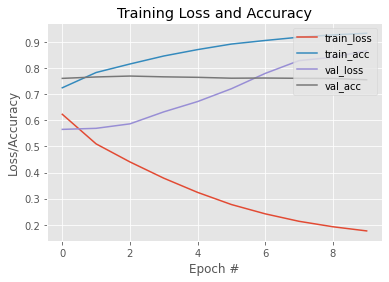

<Figure size 720x720 with 0 Axes>

In [ ]:
N= 10
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), bert_history["train_loss"], label="train_loss")
plt.plot(np.arange(0, N), bert_history["train_acc"], label="train_acc")
plt.plot(np.arange(0, N), bert_history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), bert_history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.figure(figsize = (10,10))
plt.show()

#### Our architecture

In [71]:
Config_model = {'MODEL_PATH' : "nlpaueb/bert-base-greek-uncased-v1", 
              'TOKENIZER' : BertTokenizer.from_pretrained("nlpaueb/bert-base-greek-uncased-v1"),
              'BATCH_SIZE' : 1,
              'DEVICE' : torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
              'LR' : 2e-5,
              'EPOCHS' : 4,
              'SAVE_PATH': './drive/MyDrive/Models/Our_model.pt',
              'MAX_LEN': 128
              }

In [72]:
class Athinorama(Dataset):
    
    def __init__(self, reviews, labels, tokenizer, max_len):
        super(Dataset, self).__init__()
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)
    def __getitem__(self, item):
        
        reviews = str(self.reviews[item])
        labels = self.labels[item]
        encoding = self.tokenizer.encode_plus(reviews,
                                              add_special_tokens=True,
                                              max_length=self.max_len,
                                              return_token_type_ids=True,
                                              padding='max_length',
                                              return_attention_mask=True,
                                              truncation = True,
                                              return_tensors='pt')
        
        return {'reviews': reviews,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'token_type_ids': encoding['token_type_ids'].flatten(),
                'labels': torch.tensor(labels, dtype=torch.long)
                }

def create_model_Dloader(data, tokenizer, max_len, batch_size):
    
    ds = Athinorama(reviews=data.review_cleansed.to_numpy(),
                    labels=data.label.to_numpy(),
                    tokenizer=tokenizer,
                    max_len=max_len)
    return DataLoader(ds,batch_size=batch_size,num_workers=4,shuffle=False)

In [73]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples,epoch):

    model = model.train()
    losses = []
    correct_predictions = 0
    my_index = 0
    
    for d in tqdm(data_loader,desc='Epoch ' + str(epoch)):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["labels"].to(device)
        outputs = model(input_ids=input_ids,attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        my_index = my_index + 1

    return correct_predictions.double() / n_examples, np.mean(losses)

In [74]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in tqdm(data_loader):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)
            outputs = model(input_ids=input_ids,attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
        return correct_predictions.double() / n_examples, np.mean(losses)

In [76]:
def score_model(model, data_loader, loss_fn, tokenizer, device,n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    t_reviews = []
    dec_reviews= []
    true_labels= []
    pred_labels= []
    
    with torch.no_grad():
        for d in tqdm(data_loader):
            temp_reviews = d["reviews"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)

            for i in input_ids:
              dec_reviews.append(tokenizer.decode(i))

            outputs = model(input_ids=input_ids,attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            t_reviews.append(temp_reviews)
            true_labels.append(targets)
            pred_labels.append(preds)

        accc = correct_predictions.double() / n_examples
        print('Accucary : '+str(100*accc.tolist())+' %')
        print('Correct : '+ str(correct_predictions.tolist()))
        print('Total : '+ str(n_examples))

        return t_reviews , dec_reviews , true_labels , pred_labels

In [ ]:
def run_model():
  ### hyperparameters ###
  optimizer = optim.AdamW(model.parameters(), lr=Config_model.get('LR'), )
  total_steps = len(train_data_loader) * Config_model.get('EPOCHS')
  scheduler = get_linear_schedule_with_warmup(optimizer,
                                              num_warmup_steps=0,
                                              num_training_steps=total_steps)
  loss_fn = nn.CrossEntropyLoss().to(Config_model.get('DEVICE'))

  history = defaultdict(list)
  best_accuracy = 0
  start = time.time()

  for epoch in range(Config_model.get('EPOCHS')):
      train_acc, train_loss = train_epoch(model,train_data_loader,loss_fn,optimizer,Config_model.get('DEVICE'),scheduler,len(train),epoch)
      print(f'Train loss {train_loss} accuracy {train_acc}')
      val_acc, val_loss = eval_model(model,val_data_loader,loss_fn,Config_model.get('DEVICE'),len(val))
      print(f'Validation loss {val_loss} accuracy {val_acc}')
      print()

      history['train_acc'].append(train_acc)
      history['train_loss'].append(train_loss)
      history['val_acc'].append(val_acc)
      history['val_loss'].append(val_loss)

      if val_acc > best_accuracy:
          torch.save(model.state_dict(), Config_model.get('SAVE_PATH'))
          best_accuracy = val_acc

      print(f'Best Validation Accuracy  : {best_accuracy}')
      print()
  end = time.time()
  training_time = round((end - start)/60,3)
  print('Training finished in {} minutes.'.format(str(training_time)))
  
  return history
  

In [ ]:
train_data_loader = create_model_Dloader(train, Config_model['TOKENIZER'],
                                                Config_model['MAX_LEN'],
                                                Config_model['BATCH_SIZE'])
val_data_loader = create_model_Dloader(val, Config_model['TOKENIZER'],
                                            Config_model['MAX_LEN'],
                                            Config_model['BATCH_SIZE'])
test_data_loader = create_model_Dloader(test, Config_model['TOKENIZER'],
                                              Config_model['MAX_LEN'],
                                              Config_model['BATCH_SIZE'])

In [77]:
class SentimentClassifierArch(nn.Module):
    
    def __init__(self, n_classes, batches, token_size):

        self.batch = batches
        super(SentimentClassifierArch, self).__init__()
        self.bert = BertModel.from_pretrained("nlpaueb/bert-base-greek-uncased-v1",
                                              output_hidden_states = True)
        
        embedding_length = self.bert.config.hidden_size

        self.lstm = nn.LSTM(token_size, token_size, 2,
                            bidirectional=True,
                            batch_first=True)

        self.attention = nn.MultiheadAttention(2*token_size, 8)
        self.layer_norm1 = nn.LayerNorm(2*token_size)

        self.mlp1 = nn.Linear(768, 2*token_size)

        self.conv1 = nn.Conv2d(in_channels=self.batch, out_channels=self.batch,
                               kernel_size=7, padding=3)

        pool_size = token_size
        self.maxpool = nn.AdaptiveMaxPool2d((pool_size, pool_size))

        self.mlp2 = nn.Linear(pool_size*pool_size, 64)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(64, n_classes)
 
    def forward(self, input_ids, attention_mask):
        
        _, pooled_output, hidden_stage = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask, return_dict=False)

        hidden_stage  = torch.stack(list(hidden_stage), dim=0)
        token_embeddings = torch.squeeze(hidden_stage, dim=1)
        token_embeddings = token_embeddings.permute(1,0,2)

        token_embeddings.size()
        token_vecs_sum = []

        # For each token in the sentence...
        for token in token_embeddings:

            # Sum the vectors from the last four layers.
            sum_vec = torch.sum(token[-4:], dim=0)
            
            # Use `sum_vec` to represent `token`.
            token_vecs_sum.append(sum_vec)

        stacked_tensor = torch.stack(token_vecs_sum)

        stacked_tensor = torch.transpose(stacked_tensor, 0, 1)
        
        x = self.lstm(stacked_tensor)

        x = torch.transpose(x[0], 0, 1)

        x = self.mlp1(x)

        x = torch.reshape(x, (self.batch, x.shape[0], x.shape[0]))

        x = self.conv1(x)

        x = self.maxpool(F.relu(x))

        x = torch.reshape(x, (self.batch, x.shape[1]*x.shape[1]))

        x = self.mlp2(x)

        x = self.drop(x)

        output = self.out(x)

        return output

In [ ]:
model = SentimentClassifierArch(n_classes=3,
                                batches=Config_model['BATCH_SIZE'],
                                token_size=Config_model['MAX_LEN'])
model = model.to(Config_model['DEVICE'])

Some weights of the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model_history = run_model()

Epoch 0:   0%|          | 0/44176 [00:00<?, ?it/s]

Train loss 1.4607606169789369 accuracy 0.4608384643245201


  0%|          | 0/12880 [00:00<?, ?it/s]

Validation loss 1.3053685865815445 accuracy 0.4205745341614907

Best Validation Accuracy  : 0.4205745341614907



Epoch 1:   0%|          | 0/44176 [00:00<?, ?it/s]

Train loss 1.3604186661300308 accuracy 0.37601865266207896


  0%|          | 0/12880 [00:00<?, ?it/s]

Validation loss 1.3204468566669811 accuracy 0.37624223602484475

Best Validation Accuracy  : 0.4205745341614907



Epoch 2:   0%|          | 0/44176 [00:00<?, ?it/s]

Train loss 1.3596137417078946 accuracy 0.3715818544005795


  0%|          | 0/12880 [00:00<?, ?it/s]

Validation loss 1.333047963063354 accuracy 0.37624223602484475

Best Validation Accuracy  : 0.4205745341614907



Epoch 3:   0%|          | 0/44176 [00:00<?, ?it/s]

Train loss 1.3612712060871417 accuracy 0.37348333936979355


  0%|          | 0/12880 [00:00<?, ?it/s]

Validation loss 1.3718405378577503 accuracy 0.37624223602484475

Best Validation Accuracy  : 0.4205745341614907

Training finished in 461.008 minutes.


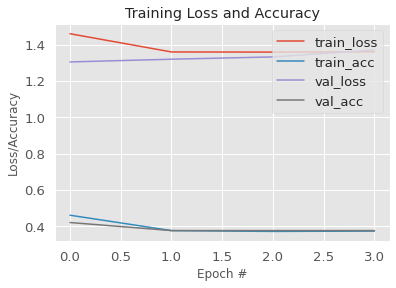

<Figure size 720x720 with 0 Axes>

In [ ]:
train_acc = []
val_acc = []
for t, v in zip(model_history["train_acc"], model_history["val_acc"]):
    train_acc.append(t.cpu().tolist())
    val_acc.append(v.cpu().tolist())

N = 4
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), model_history["train_loss"], label="train_loss")
plt.plot(np.arange(0, N), train_acc, label="train_acc")
plt.plot(np.arange(0, N), model_history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), val_acc, label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.figure(figsize = (10,10))
plt.show()

#### Load & Evaluate Models 

In [ ]:
load_T5_model = T5Model()
load_T5_model.to(Config_T5.get('DEVICE'));
load_T5_model.load_state_dict(torch.load('/content/drive/MyDrive/Models/T5_best_model.pt'))

In [64]:
load_Greek_Bert_model = GreekBert(n_classes=3)
load_Greek_Bert_model.to(Config_BERT.get('DEVICE'));
load_Greek_Bert_model.load_state_dict(torch.load(Config_BERT.get('SAVE_PATH')))

Downloading:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [ ]:
load_Greek_GPT2_model = GreekGPT2(tokenizer, n_classes=3)
load_Greek_GPT2_model.to(Config_GPT2.get('DEVICE'))
load_Greek_GPT2_model.load_state_dict(torch.load(Config_GPT2.get('SAVE_PATH')))

In [116]:
load_our_model = SentimentClassifierArch(n_classes=3,
                                batches=Config_model['BATCH_SIZE'],
                                token_size=Config_model['MAX_LEN'])

load_our_model.to(Config_model['DEVICE'])
load_our_model.load_state_dict(torch.load(Config_model.get('SAVE_PATH')))

Some weights of the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [82]:
score_df = shuffle(test[['review_cleansed','sentiment','label']])

In [65]:
dfbert = create_BERT_score_df(score_df)

  0%|          | 0/117 [00:00<?, ?it/s]

Accucary : 84.53525102493447 %
Correct : 12578
Total : 14879


In [ ]:
T5_df = create_T5_score_df(score_df)

In [111]:
GPT2_df = create_GPT2_score_df(score_df)

  0%|          | 0/930 [00:00<?, ?it/s]

Accucary : 73.53988843336245 %
Correct : 10942
Total : 14879


In [117]:
our_df = create_our_score_df(score_df)

  0%|          | 0/14879 [00:00<?, ?it/s]

Accucary : 48.63230055783318 %
Correct : 7236
Total : 14879


In [ ]:
dfbert.head()

Review  \
0  μια φορα δε φτανεικαταπληκτικη ταινιαας απολαυ...   
1  σαφως καλυτερη απο την πρωτη εχει αρκετο σασπε...   
2  μια πολυ καλη αναλαφρη ταινια με καποιες βασικ...   
3  δεν ξερω πως να κρινω την ταινια διαβασα διαφο...   
4  η οιωνιοτητα και μια νυχτα το γλυκο τσιουτσιου...   

                                 BERT_Decoded_review  True Label  \
0  [CLS] μια φορα δε φτανεικαταπληκτικη ταινιαας ...           2   
1  [CLS] σαφως καλυτερη απο την πρωτη εχει αρκετο...           1   
2  [CLS] μια πολυ καλη αναλαφρη ταινια με καποιες...           1   
3  [CLS] δεν ξερω πως να κρινω την ταινια διαβασα...           2   
4  [CLS] η οιωνιοτητα και μια νυχτα το γλυκο τσιο...           0   

   Predicted Label Model Name BERT_Prediction  
0                2       BERT            True  
1                1       BERT            True  
2                2       BERT           False  
3                2       BERT            True  
4                0       BERT            True

In [ ]:
T5_df.head()

T5_Decoded Review True Sentiment  \
0  μια φορα δε φτανεικαταπληκτικη ταινιαας απολαυ...       positive   
1  σαφως καλυτερη απο την πρωτη εχει αρκετο σασπε...        neutral   
2  μια πολυ καλη αναλαφρη ταινια με καποιες βασικ...        neutral   
3  δεν ξερω πως να κρινω την ταινια διαβασα διαφο...       positive   
4  η οιωνιοτητα και μια νυχτα το γλυκο τσιουτσιου...       negative   

  Predicted Sentiment      T5_Decoded Sentiment Model MT5_Prediction  
0            positive  <pad> positive</s> <pad>   MT5           True  
1             neutral   <pad> neutral</s> <pad>   MT5           True  
2             neutral   <pad> neutral</s> <pad>   MT5           True  
3            positive  <pad> positive</s> <pad>   MT5           True  
4            negative        <pad> negative</s>   MT5           True

In [66]:
results_confusion = confusion_matrix(dfbert['True Label'], dfbert['Predicted Label'])

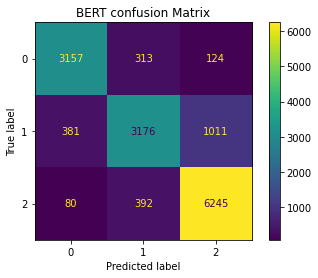

In [68]:
disp = ConfusionMatrixDisplay(results_confusion)
disp.plot()
plt.title('BERT confusion Matrix')
plt.show()

In [ ]:
target_names = ['negative', 'neutral', 'possitive']
print(classification_report(dfbert['True Label'], dfbert['Predicted Label'], target_names=target_names))

              precision    recall  f1-score   support

    negative       0.87      0.88      0.88      3594
     neutral       0.82      0.70      0.75      4568
   possitive       0.85      0.93      0.89      6717

    accuracy                           0.85     14879
   macro avg       0.85      0.83      0.84     14879
weighted avg       0.84      0.85      0.84     14879



In [112]:
results_confusion_GPT2 = confusion_matrix(GPT2_df['True Label'], GPT2_df['Predicted Label'])

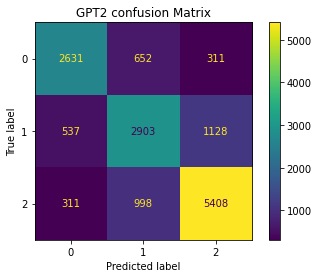

In [113]:
disp = ConfusionMatrixDisplay(results_confusion_GPT2)
disp.plot()
plt.title('GPT2 confusion Matrix')
plt.show()

In [115]:
target_names = ['negative', 'neutral', 'possitive']
print(classification_report(GPT2_df['True Label'], GPT2_df['Predicted Label'], target_names=target_names))

              precision    recall  f1-score   support

    negative       0.76      0.73      0.74      3594
     neutral       0.64      0.64      0.64      4568
   possitive       0.79      0.81      0.80      6717

    accuracy                           0.74     14879
   macro avg       0.73      0.72      0.73     14879
weighted avg       0.73      0.74      0.74     14879



In [ ]:
results_confusion_T5 = confusion_matrix(T5_df['True Sentiment'], T5_df['Predicted Sentiment'])

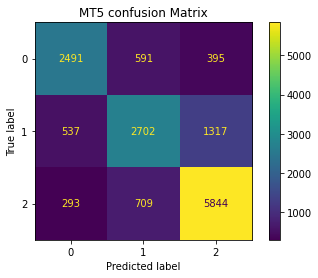

In [ ]:
disp = ConfusionMatrixDisplay(results_confusion_T5)
disp.plot()
plt.title('MT5 confusion Matrix')
plt.show()

In [ ]:
target_names = ['negative', 'neutral', 'possitive']
print(classification_report(T5_df['True Sentiment'], T5_df['Predicted Sentiment'], target_names=target_names))

              precision    recall  f1-score   support

    negative       0.75      0.72      0.73      3477
     neutral       0.68      0.59      0.63      4556
   possitive       0.77      0.85      0.81      6846

    accuracy                           0.74     14879
   macro avg       0.73      0.72      0.73     14879
weighted avg       0.74      0.74      0.74     14879



In [85]:
results_confusion_our = confusion_matrix(our_df['True Label'], our_df['Predicted Label'])

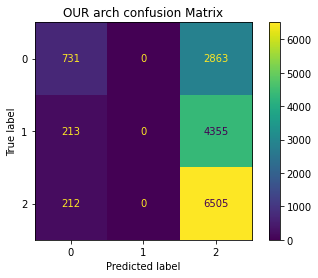

In [86]:
disp = ConfusionMatrixDisplay(results_confusion_our)
disp.plot()
plt.title('OUR arch confusion Matrix')
plt.show()

In [118]:
target_names = ['negative', 'neutral', 'possitive']
print(classification_report(our_df['True Label'], our_df['Predicted Label'], target_names=target_names))

              precision    recall  f1-score   support

    negative       0.63      0.20      0.31      3594
     neutral       0.00      0.00      0.00      4568
   possitive       0.47      0.97      0.64      6717

    accuracy                           0.49     14879
   macro avg       0.37      0.39      0.31     14879
weighted avg       0.37      0.49      0.36     14879



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### Score DataFrame BERT

In [ ]:
dfbert.head(5)

Review  \
0  μια φορα δε φτανεικαταπληκτικη ταινιαας απολαυ...   
1  σαφως καλυτερη απο την πρωτη εχει αρκετο σασπε...   
2  μια πολυ καλη αναλαφρη ταινια με καποιες βασικ...   
3  δεν ξερω πως να κρινω την ταινια διαβασα διαφο...   
4  η οιωνιοτητα και μια νυχτα το γλυκο τσιουτσιου...   

                                 BERT_Decoded_review  True Label  \
0  [CLS] μια φορα δε φτανεικαταπληκτικη ταινιαας ...           2   
1  [CLS] σαφως καλυτερη απο την πρωτη εχει αρκετο...           1   
2  [CLS] μια πολυ καλη αναλαφρη ταινια με καποιες...           1   
3  [CLS] δεν ξερω πως να κρινω την ταινια διαβασα...           2   
4  [CLS] η οιωνιοτητα και μια νυχτα το γλυκο τσιο...           0   

   Predicted Label Model Name BERT_Prediction  
0                2       BERT            True  
1                1       BERT            True  
2                2       BERT           False  
3                2       BERT            True  
4                0       BERT            True

In [ ]:
dfbert.drop('BERT_Decoded_review',axis=1).style.applymap(colorize, subset=['BERT_Prediction'])

##### Score DataFrame T5

In [ ]:
T5_df.head()

T5_Decoded Review True Sentiment  \
0  μια φορα δε φτανεικαταπληκτικη ταινιαας απολαυ...       positive   
1  σαφως καλυτερη απο την πρωτη εχει αρκετο σασπε...        neutral   
2  μια πολυ καλη αναλαφρη ταινια με καποιες βασικ...        neutral   
3  δεν ξερω πως να κρινω την ταινια διαβασα διαφο...       positive   
4  η οιωνιοτητα και μια νυχτα το γλυκο τσιουτσιου...       negative   

  Predicted Sentiment      T5_Decoded Sentiment Model MT5_Prediction  
0            positive  <pad> positive</s> <pad>   MT5           True  
1             neutral   <pad> neutral</s> <pad>   MT5           True  
2             neutral   <pad> neutral</s> <pad>   MT5           True  
3            positive  <pad> positive</s> <pad>   MT5           True  
4            negative        <pad> negative</s>   MT5           True

In [ ]:
T5_df.style.applymap(colorize, subset=['MT5_Prediction'])

##### Merge 2 DataFrames with NOT equal Predictions

In [ ]:
result = pd.concat([dfbert, T5_df], axis=1)
rslt_df = result.loc[result['BERT_Prediction']!=result['MT5_Prediction']]

In [ ]:
rslt_df.reset_index(drop=True,inplace=True)
rslt_df

Review  \
0    μια πολυ καλη αναλαφρη ταινια με καποιες βασικ...   
1    η ταινια μου αρεσε και ισως η διαρκεια της να ...   
2    χιουμορ στα ορια του παραλογισμου αλλα ταυτοχρ...   
3    ρε παιδια διαβαζω και ξαναδιαβαζω τα σχολια σα...   
4                   βλεπεται για το συνολο της ταινιας   
..                                                 ...   
186     σωστε την ελλαδα απο την πνευματικη υποβαθμιση   
187  δεν εχω διαβασει τα βιβλια ημουν ενημερος για ...   
188  εμενα μου αρεσε παντως μη πατε με αδειο  ουτε ...   
189  oχι 5 αλλα 15 αστερια στους τεραστιους queen κ...   
190  συνοδεψα ενα εξαχρονο παιδι στην ταινια και η ...   

                                   BERT_Decoded_review  True Label  \
0    [CLS] μια πολυ καλη αναλαφρη ταινια με καποιες...           1   
1    [CLS] η ταινια μου αρεσε και ισως η διαρκεια τ...           2   
2    [CLS] χιουμορ στα ορια του παραλογισμου αλλα τ...           2   
3    [CLS] ρε παιδια διαβαζω και ξαναδιαβαζω τα σχο...           0   
4    [CLS] βλεπεται για το συνολο της ταινιας [SEP]...           1   
..                                                 ...         ...   
186  [CLS] σωστε την ελλαδα απο την πνευματικη υποβ...           0   
187  [CLS] δεν εχω διαβασει τα βιβλια ημουν ενημερο...           2   
188  [CLS] εμενα μου αρεσε παντως μη πατε με αδειο ...           2   
189  [CLS] oχι 5 αλλα 15 αστερια στους τεραστιους q...           2   
190  [CLS] συνοδεψα ενα εξαχρονο παιδι στην ταινια ...           2   

     Predicted Label Model Name BERT_Prediction  \
0                  2       BERT           False   
1                  2       BERT            True   
2                  2       BERT            True   
3                  1       BERT           False   
4                  1       BERT            True   
..               ...        ...             ...   
186                0       BERT            True   
187                2       BERT            True   
188                2       BERT            True   
189                1       BERT           False   
190                2       BERT            True   

                                     T5_Decoded Review True Sentiment  \
0    μια πολυ καλη αναλαφρη ταινια με καποιες βασικ...        neutral   
1    η ταινια μου αρεσε και ισως η διαρκεια της να ...       positive   
2    χιουμορ στα ορια του παραλογισμου αλλα ταυτοχρ...       positive   
3    ρε παιδια διαβαζω και ξαναδιαβαζω τα σχολια σα...       negative   
4    βλεπεται για το συνολο της ταινιας</s> <pad> <...        neutral   
..                                                 ...            ...   
186  σωστε την ελλαδα απο την πνευματικη υποβαθμιση...       negative   
187  δεν εχω διαβασει τα βιβλια ημουν ενημερος για ...       positive   
188  εμενα μου αρεσε παντως μη πατε με αδειο ουτε κ...       positive   
189  oχι 5 αλλα 15 αστερια στους τεραστιους queen κ...       positive   
190  συνοδεψα ενα εξαχρονο παιδι στην ταινια και η ...       positive   

    Predicted Sentiment      T5_Decoded Sentiment Model MT5_Prediction  
0               neutral   <pad> neutral</s> <pad>   MT5           True  
1               neutral   <pad> neutral</s> <pad>   MT5          False  
2               neutral   <pad> neutral</s> <pad>   MT5          False  
3              negative        <pad> negative</s>   MT5           True  
4              negative        <pad> negative</s>   MT5          False  
..                  ...                       ...   ...            ...  
186            positive  <pad> positive</s> <pad>   MT5          False  
187             neutral   <pad> neutral</s> <pad>   MT5          False  
188             neutral   <pad> neutral</s> <pad>   MT5          False  
189            positive  <pad> positive</s> <pad>   MT5           True  
190             neutral   <pad> neutral</s> <pad>   MT5          False  

[191 rows x 12 columns]

In [ ]:
# confusion_matrix